In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import torch
import torch.nn as nn
import gymnasium as gym
import random
import numpy as np
from copy import deepcopy
from collections import deque
from torch_mas.batch_head_alternative import AlternativeBatchHead
from torch_mas.batch_head import BatchHead
from torch_mas.agents.batch_agents_linear_reg_alternative import BatchLinearAgent, BatchLinearAgentSGD

device = "cuda"

In [13]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return (
            torch.as_tensor(np.array(state), dtype=torch.float).to(device),
            torch.as_tensor(np.array(action), dtype=torch.long).to(device),
            torch.as_tensor(np.array(reward), dtype=torch.float).to(device),
            torch.as_tensor(np.array(next_state), dtype=torch.float).to(device),
            torch.as_tensor(np.array(done), dtype=torch.float).to(device)
        )
    
    def __len__(self):
        return len(self.buffer)

In [14]:
env = gym.make("CartPole-v1")
test_env = gym.make("CartPole-v1")

buffer_size = 50000
replay_buffer = ReplayBuffer(buffer_size)

next_obs, infos = env.reset()

warmup_steps = 10000
done = False
for s in range(warmup_steps):
    obs = next_obs
    a = env.action_space.sample()
    next_obs, reward, done, truncated, infos = env.step(a)
    replay_buffer.push(obs, a, reward, next_obs, done)
    if done:
        next_obs, infos = env.reset()

In [15]:
from torch_mas.agents.batch_agents_linear_reg_alternative import BatchLinearAgentAVRT


obs_dim = env.observation_space.shape[-1]
action_dim = env.action_space.n
gamma = 0.9
batch_size = 2048
epsilon_ini = 1.0
epsilon_end = 0.2
epsilon_decay = 0.99995
target_update_freq = 300
update_freq = 10
n_epochs = 100
n_step_per_epoch = 500
_step = 0

obs, _, _, _, _ = replay_buffer.sample(500)


model = AlternativeBatchHead(
    obs_dim,
    action_dim,
    R=obs.std(0)/1.5,
    n_epochs=20,
    batch_size=batch_size,
    agents=BatchLinearAgent,
    agents_kwargs={
        "l1": 1e-8,
        "alpha": 0.3,
        "memory_length": 30,
        "lr": 1e-1,
        "n_optim_steps": 1
    },
    device=device
)
target_model = AlternativeBatchHead(
    obs_dim,
    action_dim,
    R=obs.std(0)/1.5,
    n_epochs=20,
    batch_size=batch_size,
    agents=BatchLinearAgentAVRT,
    agents_kwargs={
        "l1": 1e-8,
        "alpha": 0.2,
        "memory_length": 10,
        "lr": 3e-1,
        "n_optim_steps": 1
    },
    device=device
)

batch = replay_buffer.sample(batch_size)

def update_target(q_network, target_q_network):
    target_q_network.agents.hypercubes = q_network.agents.hypercubes.clone()
    target_q_network.agents.models = q_network.agents.models.clone()
    target_q_network.agents.memory_sizes = q_network.agents.memory_sizes.clone()

def update(q_network, target_q_network, batch):
    b_obs, b_actions, b_rewards, b_next_obs, b_dones = batch

    current_q_values = q_network.predict(b_obs)
    with torch.no_grad():
        next_q_values = target_q_network.predict(b_next_obs).max(1)[0]
        next_q_values = b_rewards + (1 - b_dones) * gamma * next_q_values
        target_q_values = current_q_values.clone()
        target_q_values[torch.arange(batch_size), b_actions] = next_q_values

    model.partial_fit(b_obs, target_q_values)

def select_action(q_network, obs):
    obs = torch.as_tensor(obs, dtype=torch.float, device=device)
    if len(obs.shape) < 2:
        obs = obs.unsqueeze(0)
    q_values = q_network.predict(obs)
    return q_values.argmax(-1).cpu().detach().squeeze().numpy()

def eval(q_network, env, n_episodes=5):
    rewards = 0
    for i in range(n_episodes):
        obs, infos = env.reset()
        done = False
        while not done:
            a = int(select_action(q_network, obs))
            obs, reward, done, truncated, infos = env.step(a)
            rewards += reward
            done = done or truncated
    return rewards / n_episodes

update(model, target_model, batch)
select_action(model, obs)

# Training
eval_hist = []
done = False
next_obs, infos = env.reset()
epsilon = epsilon_ini
for e in range(n_epochs):
    rewards = 0
    reward_hist = []
    for s in range(n_step_per_epoch):
        obs = next_obs
        if random.random() < epsilon:
            a = env.action_space.sample()
        else:
            a = int(select_action(model, obs))
        next_obs, reward, done, truncated, infos = env.step(a)
        replay_buffer.push(obs, a, reward, next_obs, done)
        rewards += reward
        done = done or truncated
        if done:
            next_obs, infos = env.reset()
            reward_hist += [rewards]
            rewards = 0
        
        # update epsilon
        epsilon = max(epsilon_end, epsilon*epsilon_decay)
        # update
        if _step % update_freq == 0:
            batch = replay_buffer.sample(batch_size)
            update(model, target_model, batch)
        # update target
        if _step % target_update_freq == 0:
            update_target(model, target_model)
        _step += 1
    eval_rewards = eval(model, test_env, n_episodes=3)
    eval_hist += [eval_rewards]
    print(f"[EPOCH {e}] epsilon: {epsilon:.2f} | eval rewards: {eval_rewards:.2f}| ep rewards: {np.mean(reward_hist):.2f} | n_agents: {model.agents.n_agents}")


[EPOCH 0] epsilon: 0.98 | eval rewards: 39.67| ep rewards: 21.91 | n_agents: 664
[EPOCH 1] epsilon: 0.95 | eval rewards: 22.67| ep rewards: 20.96 | n_agents: 666
[EPOCH 2] epsilon: 0.93 | eval rewards: 36.00| ep rewards: 20.12 | n_agents: 667
[EPOCH 3] epsilon: 0.90 | eval rewards: 34.33| ep rewards: 20.00 | n_agents: 668
[EPOCH 4] epsilon: 0.88 | eval rewards: 110.33| ep rewards: 20.75 | n_agents: 676
[EPOCH 5] epsilon: 0.86 | eval rewards: 38.00| ep rewards: 22.32 | n_agents: 676
[EPOCH 6] epsilon: 0.84 | eval rewards: 55.00| ep rewards: 21.04 | n_agents: 676
[EPOCH 7] epsilon: 0.82 | eval rewards: 52.33| ep rewards: 34.93 | n_agents: 682
[EPOCH 8] epsilon: 0.80 | eval rewards: 97.67| ep rewards: 24.21 | n_agents: 686
[EPOCH 9] epsilon: 0.78 | eval rewards: 71.67| ep rewards: 22.73 | n_agents: 687
[EPOCH 10] epsilon: 0.76 | eval rewards: 44.67| ep rewards: 24.95 | n_agents: 688
[EPOCH 11] epsilon: 0.74 | eval rewards: 98.67| ep rewards: 27.12 | n_agents: 688
[EPOCH 12] epsilon: 0.72 

KeyboardInterrupt: 

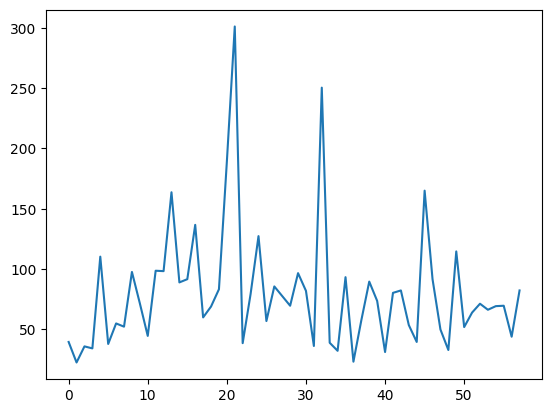

In [16]:
import matplotlib.pyplot as plt

plt.plot(eval_hist)